In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl



%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle
import bobsegutils as bsu

from skimage.draw import circle

import csv

from skimage import io

import math

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
### Read the results csv file, delete all entries which are not coordinates and write it as a new csv file
for i in range(1,20,1):
    #with open("/Users/prakash/Desktop/BobSegDataAndResults/FlowQuantification/time"+str(i)+"-"+str(i+1)+"/time_00"+str(i+1)+".csv","r") as source:
    with open("/Users/prakash/Desktop/BobSegDataAndResults/FlowQuantificationDataset2/time"+str(i)+"-"+str(i+1)+"/time_00"+str(i+1)+".csv","r") as source:
        rdr= csv.reader( source )
        with open("/Users/prakash/Desktop/BobSegDataAndResults/FlowQuantificationDataset2/time"+str(i)+"-"+str(i+1)+"/"+"Resultstime"+str(i)+"-"+str(i+1)+".csv","w") as result:
        #with open("/Users/prakash/Desktop/BobSegDataAndResults/FlowQuantification/time"+str(i)+"-"+str(i+1)+"/"+"Resultstime"+str(i)+"-"+str(i+1)+".csv","w") as result:
            wtr= csv.writer( result )
            for r in rdr:
                wtr.writerow( (r[5], r[6]) )

### The manually tracked coordinates from Fiji are processed before plotting

In [3]:
def load_file(filename):
    '''Make a list of tuples from a csv file
    '''
    fp = open(filename, 'Ur')
    data_list = []
    for line in fp:
        data_list.append(tuple((line.strip().split(','))))
    fp.close()
    return data_list

In [4]:
# The above created list elememts are string, we convert them to float below
center_points = []
manual_track_points = []
for f in range(1,20,1):
    #data_list = load_file("/Users/prakash/Desktop/BobSegDataAndResults/FlowQuantification/time"+str(f)+"-"+str(f+1)+"/Resultstime"+str(f)+"-"+str(f+1)+".csv")
    data_list = load_file("/Users/prakash/Desktop/BobSegDataAndResults/FlowQuantificationDataset2/time"+str(f)+"-"+str(f+1)+"/Resultstime"+str(f)+"-"+str(f+1)+".csv")
    datal = data_list[1:] # Ignoring the header row (first row of csv file)
    half = int(len(datal)/2)
    string_first_half = datal[0:half]
    string_second_half = datal[half:]
    float_first_half_list = []
    float_second_half_list = []
    for element in range(len(string_first_half)):
        number_element_first_half = []
        number_element_second_half = []
        number_element_first_half.append((float(string_first_half[element][0])))
        number_element_first_half.append((float(string_first_half[element][1])))
        float_first_half_list.append(tuple(number_element_first_half))
        number_element_second_half.append((float(string_second_half[element][0])))
        number_element_second_half.append((float(string_second_half[element][1])))
        float_second_half_list.append(tuple(number_element_second_half))
    center_points.append(float_first_half_list)
    manual_track_points.append(float_second_half_list)

/Users/prakash/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.


### Optical Flow computation 

In [5]:
filename = '/Users/prakash/Dropbox/BobSegMarkData/2018-04-17_fromMark/MAX_20180417_NMY-2_speed-test-01-05_MYOSIN_ALONE_copy.tif'
myosin_channel = imread(filename)
print('Shape of stack:', myosin_channel.shape)
sigma = [0.,2,2]
myosin_channel_smooth = gaussian(myosin_channel,sigma)

Shape of stack: (31, 331, 406)


In [6]:
flows = bsu.compute_flow( myosin_channel)
flow_x, flow_y = bsu.split_flow_components( flows )
avg_flow_x = bsu.flow_average(flow_x, 1)
avg_flow_y = bsu.flow_average(flow_y, 1)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

............................... ...done!


In [7]:
flow_points = []
for frame, points in enumerate(center_points):
    flow_points_per_frame = []
    for i in range(len(points)):
        position = bsu.update_pos(points[i], frame, avg_flow_x, avg_flow_y )
        flow_points_per_frame.append(position)
    flow_points.append(flow_points_per_frame)

The cell below makes a flat list out of flow_points, maunal_track_points and center_points

In [8]:
center_points_flat_list = [item for sublist in center_points for item in sublist]
manual_track_points_flat_list = [item for sublist in manual_track_points for item in sublist]
flow_points_flat_list = [item for sublist in flow_points for item in sublist]

In [9]:
#cumulative_offset = 0
cumulative_relative_offset = 0
offset_list = []
relative_offset_list = []
for i in range(len(center_points_flat_list)):
    offset = bsu.euclid_dist(manual_track_points_flat_list[i], flow_points_flat_list[i])
    r = bsu.euclid_dist(manual_track_points_flat_list[i], center_points_flat_list[i])
    relative_offset = offset/r
    offset_list.append(offset)
    relative_offset_list.append(relative_offset)
    #cumulative_offset = cumulative_offset + offset
    cumulative_relative_offset = cumulative_relative_offset + relative_offset
average_cumulative_relative_offset = cumulative_relative_offset / len(center_points_flat_list)

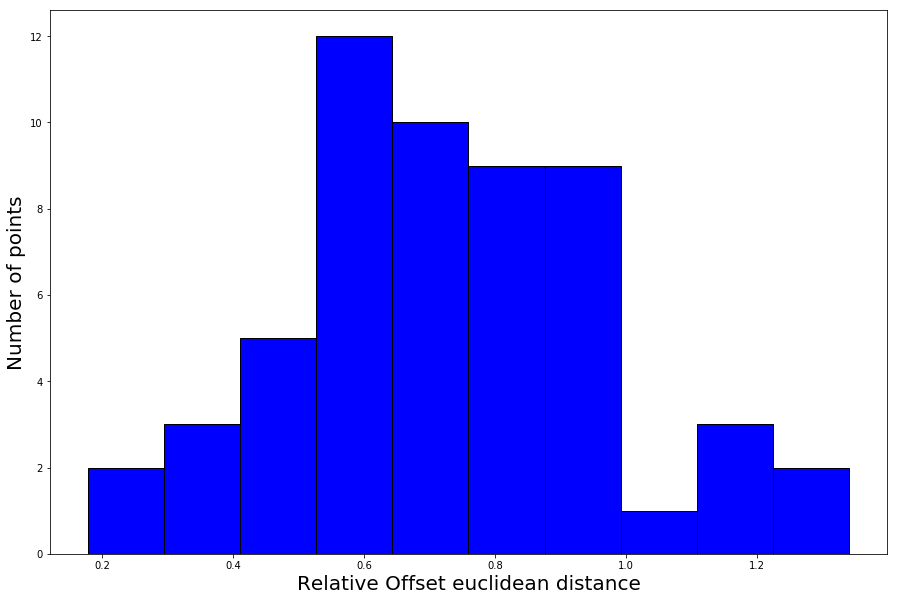

In [10]:
plt.hist(relative_offset_list,histtype='bar', color='blue', ec='black')
plt.xlabel('Relative Offset euclidean distance',fontsize=20)
plt.ylabel('Number of points',fontsize=20)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

In [11]:
print(average_cumulative_relative_offset)

0.731685754682


### Flow Visualization Strategies and Computing and plotting results

In [12]:
center_to_manual_vectors = bsu.subVector(center_points_flat_list, manual_track_points_flat_list)
center_to_flow_vectors = bsu.subVector(center_points_flat_list, flow_points_flat_list)
delta = []
for i in range(len(center_to_manual_vectors)):
    angle_rad = bsu.angle_between( center_to_flow_vectors[i], center_to_manual_vectors[i])
    angle_deg = math.degrees(angle_rad)
    delta.append(angle_deg)

In [13]:
pixel_lag = []
relative_pixel_lag = []
for i in range(len(center_points_flat_list)):
    r2 = bsu.euclid_dist(center_points_flat_list[i], flow_points_flat_list[i])
    r1 = bsu.euclid_dist(center_points_flat_list[i], manual_track_points_flat_list[i])
    position_offset = r2-r1
    relative_position_offset = abs(position_offset)/r1
    pixel_lag.append(position_offset)
    relative_pixel_lag.append(relative_position_offset*100)

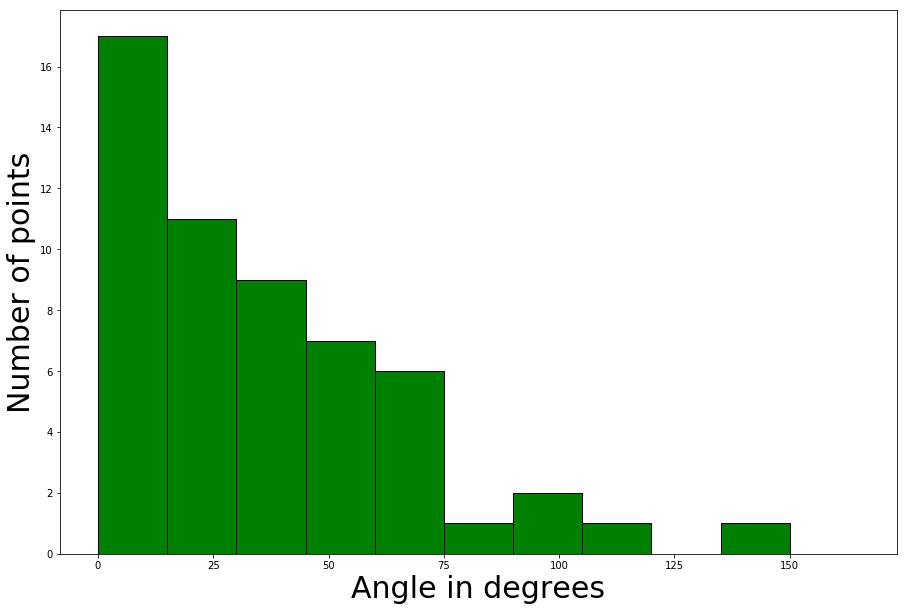

In [14]:
plt.hist(delta[1:], bins=range(0,180,15),histtype='bar', color='green', ec='black')
plt.xlabel('Angle in degrees',fontsize=30)
plt.ylabel('Number of points',fontsize=30)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

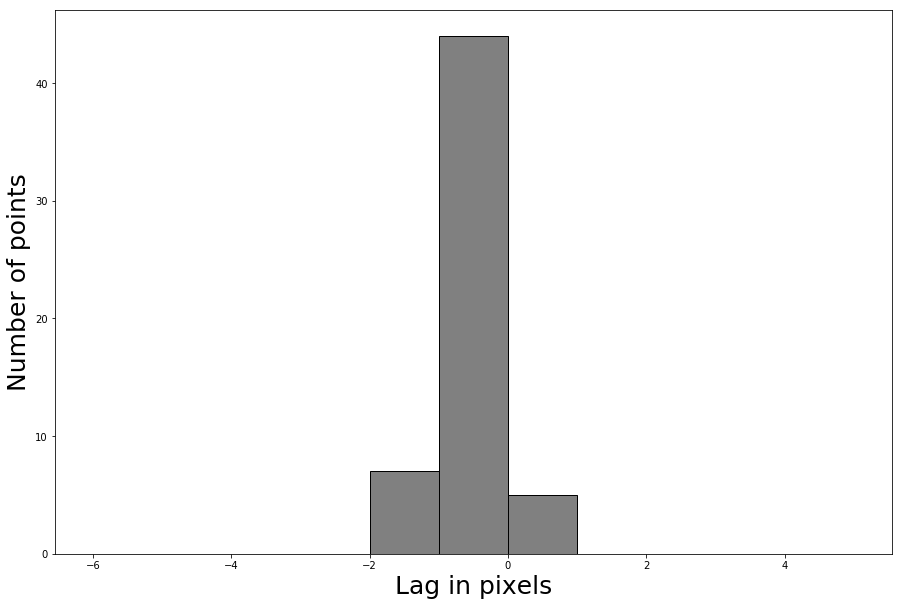

In [15]:
plt.hist(pixel_lag, bins=range(-6,6,1),histtype='bar', color='gray', ec='black')
plt.xlabel('Lag in pixels',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

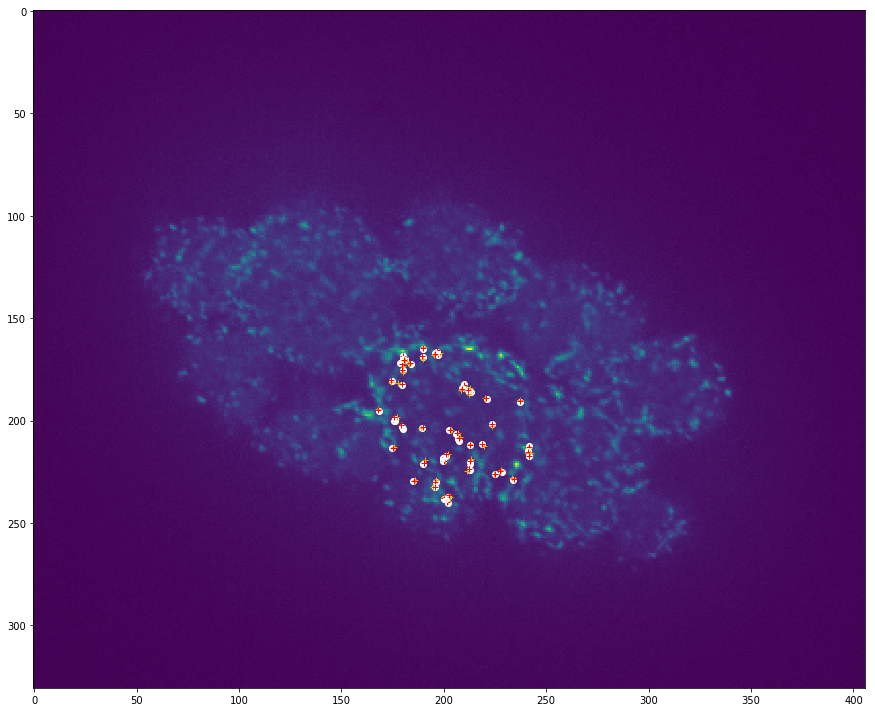

In [16]:
fig = plt.figure()
for element in range(len(center_points_flat_list)):
    plt.plot(center_points_flat_list[element][0],center_points_flat_list[element][1],'o',color='white') #Starting position
    plt.plot(manual_track_points_flat_list[element][0],manual_track_points_flat_list[element][1],'+',color='orange') #Updated position by flow computation
    plt.plot(flow_points_flat_list[element][0],flow_points_flat_list[element][1],'+',color='red') #Updated position by flow computation
    plt.imshow(myosin_channel[-1]) 
    fig.tight_layout()    